In [21]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
from scipy.stats import qmc
from scipy.spatial import distance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm
from pyDOE import lhs
import os
from scipy.stats.qmc import Sobol
from itertools import product

In [22]:
def uniform_sampling(num_samples, dim):
    return np.random.uniform(size=(num_samples, dim))

def random_dirichlet_sampling(num_samples, dim):
    return np.random.dirichlet(np.ones(dim), size=num_samples)

def latin_hypercube_sampling(num_samples, dim):
    return lhs(dim, samples=num_samples, criterion='maximin')

def sobol_sampling(num_samples, dim):
    sampler = Sobol(d=dim, scramble=True)
    return sampler.random(n=num_samples)

# Set the seed for the notebook
seed = 42
np.random.seed(seed)
random.seed(seed)

In [23]:
# Function to convert CMYK to RGB
def CMYK_to_RGB(c, m, y, k):
    R = (1 - c) * (1 - k)
    G = (1 - m) * (1 - k)
    B = (1 - y) * (1 - k)
    return np.array([R, G, B])

# Function to convert RGB to CMYK
def RGB_to_CMYK(RGB_sample):
    Red = RGB_sample[0]/255
    Green = RGB_sample[1]/255
    Blue = RGB_sample[2]/255

    Black = min(1-Red,1-Green,1-Blue)
    Cyan = (1-Red-Black)/(1-Black)
    Magenta = (1-Green-Black)/(1-Black)
    Yellow  = (1-Blue-Black)/(1-Black)

    return np.array([Cyan, Magenta, Yellow, Black])

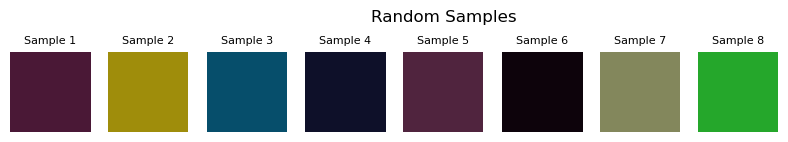

In [ ]:
# Initialize variables
n_samples = 8; dimensions = 4
np.random.seed(seed)

# Try changing the sampling method to see how the algorithm performs.
random_CMYK = latin_hypercube_sampling(n_samples, dimensions)
#random_CMYK = uniform_sampling(n_samples, dimensions)
#random_CMYK = random_dirichlet_sampling(n_samples, dimensions)
#random_CMYK = sobol_sampling(n_samples, dimensions)

# Convert to RGB
random_RGB = np.array([CMYK_to_RGB(*cmyk) for cmyk in random_CMYK])

### Generate target color

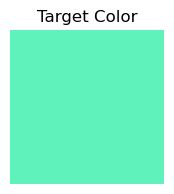

In [ ]:
np.random.seed(seed)

target_color = (np.random.rand(3)*255).astype(int)  # Random target color
target_color_norm = np.array(target_color)/255
target_color_CMYK = RGB_to_CMYK(target_color)
target_string = ', '.join(str(x) for x in target_color)

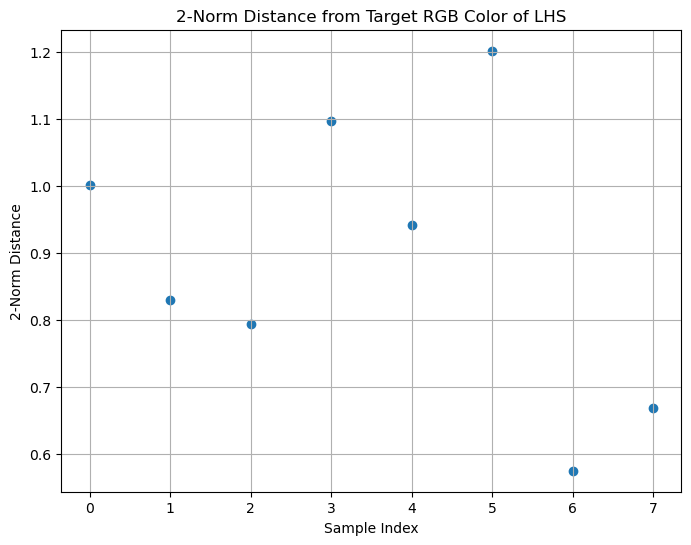

In [ ]:
# Calculate the 2-norm distance for each sample color
def norm_error(norm_samples, target_color):
    return [np.linalg.norm(np.array(sample) - np.array(target_color)/255) for sample in norm_samples]

sample_distances = norm_error(random_RGB, target_color)

In [27]:
# Optimization Parameters
hyperparameter = 0.01
threshold = 0.025
scaling_factor = 50

# Gaussian Process Regression model
kernel = C(constant_value=1, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=False)

# Expected Improvement maximizes implicetly
def expected_improvement(X, X_sample, y_sample, model):
    mu, sigma = model.predict(X, return_std=True)

    optiminal_sample = np.min(y_sample)

    with np.errstate(divide="ignore"):

        imp = mu - optiminal_sample - hyperparameter
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.flatten()

# Function to propose the next sample point using Expected Improvement
def propose_location(acquisition, X_sample, y_sample, bounds, n_restarts=25):
    dim = X_sample.shape[1]

    def min_obj(x):
        return -acquisition(x.reshape(-1, dim), X_sample, y_sample, gp)

    # Starting points for optimization
    x0_list = np.random.uniform(0, 1, size=(n_restarts, dim))
    best_x, best_val = None, float("inf")
    for x0 in x0_list:
        res = minimize(min_obj, x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < best_val:
            best_val = res.fun
            best_x = res.x
    return best_x

In [ ]:
# Initialize storage for attempts
user_attempts = []
cmyk_attempts = []
bo_guesses = []
user_distances = []
bo_distances = []
X_samples = []
y_samples = []
win_threshold = 5

# Initialize variables
n_features = 4  # CMYK components
bounds = [(0, 1)] * n_features  # CMYK values are normalized between 0 and 1

X = random_CMYK
y = -np.linalg.norm(X - target_color_CMYK, axis=1)

# Create interactive sliders
c_slider = widgets.FloatSlider(description="Cyan (%)", min=0, max=1, step=0.01, value=0.5, continuous_update=False)
m_slider = widgets.FloatSlider(description="Magenta (%)", min=0, max=1, step=0.01, value=0.5, continuous_update=False)
y_slider = widgets.FloatSlider(description="Yellow (%)", min=0, max=1, step=0.01, value=0.5, continuous_update=False)
k_slider = widgets.FloatSlider(description="Black (%)", min=0, max=1, step=0.01, value=0.5, continuous_update=False)
submit_button = widgets.Button(description="Submit")

# Title Widget
title = widgets.HTML("<h2>Color Optimization: Minimize Error to Reach Target Color</h2>")

# Output widgets for displaying colors and attempts
user_output = widgets.Output()
bo_output = widgets.Output()
random_output = widgets.Output()
attempt_tracker = widgets.IntText(value=0, description="Attempts:", disabled=True)
min_distance_display = widgets.FloatText(value=float("inf"), description="Best Guess:", disabled=True)
winner_display = widgets.HTML(value="<h2 style='text-align:center; font-size: 20px;'>Goal: < "+str(win_threshold)+"% Error before BO</h2>")
error_output = widgets.Output()
gp_plot_output = widgets.Output()
ei_plot_output = widgets.Output()
restart_button = widgets.Button(description="New Color", button_style='danger')
restart_button.layout = widgets.Layout(margin='0px 0px 0px 30px')  # Add left margin

In [ ]:
# Function to update the display on button click
def submit_color(_):
    global user_attempts, cmyk_attempts, X, y, bo_guesses, bo_distances, gp

    # Convert user CMYK input to RGB
    cmyk_values = (c_slider.value, m_slider.value, y_slider.value, k_slider.value)
    user_rgb = (CMYK_to_RGB(*cmyk_values) * 255).astype(int)

    # Compute Euclidean distance from the target color
    distance = np.linalg.norm(cmyk_values - target_color_CMYK) * scaling_factor

    if np.isnan(distance) or np.isinf(distance):
        distance = 0.0

    # Store attempt data
    user_attempts.append(user_rgb)
    cmyk_attempts.append(cmyk_values)
    user_distances.append(distance)

    # Update attempt count
    attempt_tracker.value = len(user_attempts)

    # Update the minimum distance
    min_distance_display.value = round(min(user_distances), 1) if user_distances else None

    # Only run BO if the best distance is greater than the threshold
    if not bo_distances or min(bo_distances) > (win_threshold/100):
        if (len(bo_guesses) >= 10):
            new_random = np.random.rand(4)  # New CMYK random sample
            random_y = -np.linalg.norm(new_random - target_color_CMYK)  # Negative distance

            # Append the new sample to the dataset
            X_samples.append(new_random)
            y_samples.append(random_y)

            X = np.vstack((X, new_random))
            y = np.append(y, random_y)

        # Update GP model
        gp.fit(X, y)  # Fit GP model to the current data

        # Propose the next sampling point based on Bayesian Optimization
        X_next = propose_location(expected_improvement, X, y, bounds)
        y_next = -np.linalg.norm(X_next - target_color_CMYK)  # Compute the negative distance

        # Append the new sample to the dataset
        X_samples.append(X_next)
        y_samples.append(y_next)

        X = np.vstack((X, X_next))
        y = np.append(y, y_next)

        # Track the selected color
        bo_rgb = (CMYK_to_RGB(X_next[0],X_next[1],X_next[2],X_next[3])*255).astype(int)
        bo_distances.append(np.linalg.norm(X_next - target_color_CMYK)*scaling_factor) # Track the negative distance (closer to target)
        bo_guesses.append(X_next)

    # Determine the winner
    if any(d < win_threshold for d in user_distances):
        winner_display.value = "<h2 style='text-align:center; font-size: 24px;'>User Wins!</h2>"
    elif any(d < win_threshold for d in bo_distances):
        winner_display.value = "<h2 style='text-align:center; font-size: 24px;'>BO Wins!</h2>"
    else:
        winner_display.value = "<h2 style='text-align:center; font-size: 20px;'>Goal: < "+str(win_threshold)+"% Error before BO</h2>"

    # Clear output and redraw user attempts
    with user_output:
        clear_output(wait=True)

        # Determine the number of rows needed for wrapping
        num_attempts = len(user_attempts)
        num_cols = 8  # Max colors per row
        num_rows = -(-num_attempts // num_cols)  # Ceiling division

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.1), constrained_layout=True)
        axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure correct shape

        # Plot attempts with CMYK labels and distances
        for i, (rgb, cmyk, dist) in enumerate(zip(user_attempts, cmyk_attempts, user_distances)):
            row, col = divmod(i, num_cols)
            axes[row, col].imshow([[rgb]])
            axes[row, col].set_title(
                f"C:{cmyk[0]:.2f}% M:{cmyk[1]:.2f}%\nY:{cmyk[2]:.2f}% K:{cmyk[3]:.2f}%\nError:{dist:.1f}%", fontsize=7)
            axes[row, col].axis("off")

        # Hide unused subplots
        for i in range(num_attempts, num_rows * num_cols):
            row, col = divmod(i, num_cols)
            axes[row, col].axis("off")

        plt.suptitle("User Attempts", fontsize=12)
        plt.show()

    # Clear output and redraw BO guesses
    with bo_output:
        clear_output(wait=True)

        num_bo_guesses = len(bo_guesses)
        num_cols = 8
        num_rows = -(-num_bo_guesses // num_cols)

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.1), constrained_layout=True)
        axes = np.array(axes).reshape(num_rows, num_cols)

        # Plot BO guesses
        for i, (bo_guess, dist) in enumerate(zip(bo_guesses, bo_distances)):
            row, col = divmod(i, num_cols)
            bo_rgb = CMYK_to_RGB(*bo_guess)
            bo_rgb_255 = (bo_rgb * 255).astype(int)
            axes[row, col].imshow([[bo_rgb]])
            axes[row, col].set_title(f"R:{bo_rgb_255[0]} G:{bo_rgb_255[1]}\n B:{bo_rgb_255[2]}\nError:{dist:.1f}%", fontsize=7)
            axes[row, col].axis("off")

        # Hide extra subplots
        for i in range(num_bo_guesses, num_rows * num_cols):
            row, col = divmod(i, num_cols)
            axes[row, col].axis("off")

        plt.suptitle("BO Attempts", fontsize=12)
        plt.show()

# Attach the button click event
submit_button.on_click(submit_color)

# Display target color and attempt tracker immediately
target_display = widgets.Output()
with target_display:
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow([[target_color]])
    ax.axis("off")
    plt.title("Target Color (" + target_string + ")")
    plt.show()

# Show the initial random sampling row (remains visible)
with random_output:
    fig, axes = plt.subplots(1, 8, figsize=(15, 2))
    for i, (rgb, cmyk) in enumerate(zip(random_RGB, random_CMYK)):
        axes[i].imshow([[rgb]])
        axes[i].set_title(f"C:{cmyk[0]:.2f}% M:{cmyk[1]:.2f}% \n Y:{cmyk[2]:.2f}% K:{cmyk[3]:.2f}%", fontsize=7)
        axes[i].axis("off")

    plt.suptitle("Random Samples", fontsize=12)
    plt.tight_layout()
    plt.show()

def restart_game(_):
    global user_attempts, cmyk_attempts, user_distances, X, y, bo_guesses, bo_distances, gp
    global target_color_CMYK, target_color, target_string, X_samples, y_samples

    # Reset all history
    user_attempts = []
    cmyk_attempts = []
    user_distances = []
    bo_guesses = []
    bo_distances = []
    X_samples = []
    y_samples = []

    # Generate new random CMYK target color
    target_color = (np.random.rand(3)*255).astype(int)  # Random target color
    target_color_CMYK = RGB_to_CMYK(target_color)
    target_string = ', '.join(str(x) for x in target_color)

    # Generate new random samples
    random_CMYK = latin_hypercube_sampling(n_samples, dimensions)
    random_RGB = np.array([CMYK_to_RGB(*c) for c in random_CMYK])
    X = random_CMYK
    y = np.array([-np.linalg.norm(x - target_color_CMYK) for x in X])
    X_samples = list(X.copy())
    y_samples = list(y.copy())

    # Reset GP model
    kernel = C(constant_value=1, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=False)

    # Reset widgets
    attempt_tracker.value = 0
    min_distance_display.value = 0.0
    winner_display.value = "<h2 style='text-align:center; font-size: 20px;'>Goal: < "+str(win_threshold)+"% Error before BO</h2>"

    # Update target color display
    with target_display:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow([[target_color]])
        ax.axis("off")
        plt.title("Target Color (" + target_string + ")")
        plt.show()

    # Update random samples display
    with random_output:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 8, figsize=(15, 2))
        for i, (rgb, cmyk) in enumerate(zip(random_RGB, random_CMYK)):
            axes[i].imshow([[rgb]])
            axes[i].set_title(f"C:{cmyk[0]:.2f}% M:{cmyk[1]:.2f}%\nY:{cmyk[2]:.2f}% K:{cmyk[3]:.2f}%", fontsize=7)
            axes[i].axis("off")
        plt.suptitle("Random Samples", fontsize=12)
        plt.tight_layout()
        plt.show()

    # Clear other outputs
    with user_output:
        clear_output(wait=False)
    with bo_output:
        clear_output(wait=False)

restart_button.on_click(restart_game)

# Layout: Sliders + Target Color + Attempt Tracker + Min Distance in the same row
control_panel = widgets.HBox([widgets.VBox([c_slider, m_slider, y_slider, k_slider, submit_button]),
                              target_display,
                              widgets.VBox([attempt_tracker, min_distance_display, winner_display]),restart_button])

In [ ]:
# Display everything
display(widgets.VBox([title, control_panel, user_output, bo_output, random_output]))